In [83]:
import gmaps
import numpy as np
import gmaps.datasets
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
import influxdb
import requests
import impyute
from datetime import datetime as dt
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import pykalman as pk
import statsmodels as sm
from statsmodels.tsa.arima_model import ARIMA
from numpy import ma
import itertools
import warnings

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [4]:
auth = pd.read_json('../auth.json',typ='series')
client = influxdb.DataFrameClient(auth.influxdb['hostname'], 8086, ssl=True, username=auth.influxdb['username'], password=auth.influxdb['password'])

# PM data
## Data cleaning

In [5]:
coords = client.query("select * from coords", database="sensenet_coords")
userData = coords['coords']
userData = userData.reset_index(drop=True)
userData=userData.rename(columns={"box":"dev_id"})
userData.dev_id=[(int)(x.split('x')[-1]) for x in userData.dev_id]
userData

,dev_id,latitude,longitude,type,uid
0,11,38.029883,-78.484047,outdoor,LF
1,10,38.030613,-78.479057,outdoor,CCI
2,9,38.025759,-78.469295,outdoor,Jon K.
3,8,38.047450,-78.483030,outdoor,Angela O.
4,7,38.025570,-78.516610,outdoor,Lane R.
5,6,38.025092,-78.503586,outdoor,Jimmy H.
6,5,38.045801,-78.503947,outdoor,Francis R.
7,4,38.027580,-78.515191,outdoor,Alex N.
8,3,38.024780,-78.484580,outdoor,Lucas A.
9,2,38.065460,-78.495820,outdoor,Zihao Z.


In [6]:
complete_df = client.query("select * from \"sensenet-test\"", database="sensornet_db")
pmData = complete_df['sensenet-test']
pmData[['dev_id','pm25', 'pm10', 'co2', 'temp', 'humidity', 'gtw_id', 'rssi', 'snr']].head()
#sbox2 has basically no data
boxes = ['sbox'+str(i) for i in range(3,12)]
pmData = pmData[pmData.dev_id.isin(boxes)]
pmData.dev_id=[(int)(x.split('x')[-1]) for x in pmData.dev_id]
pmData=pmData.join(userData,on='dev_id',rsuffix='_user',how="outer")
pmData=pmData.reset_index()
pmData=pmData.rename(columns={"index":"time"})
pmData.head()

,time,airtime,channel,co2,data_rate,dev_id,frequency,gtw_id,humidity,latitude,...,pm25,rssi,snr,temp,timestamp,dev_id_user,latitude_user,longitude_user,type,uid
0,2020-02-03 00:36:03.779007152+00:00,61696000.0,3.0,144.0,SF7BW125,6,904.5,sds-gateway-3,62.89,38.026337,...,0.0,-14.0,9.00,12.52,4.366491e+08,5.0,38.045801,-78.503947,outdoor,Francis R.
1,2020-02-03 00:51:03.804609070+00:00,61696000.0,7.0,140.0,SF7BW125,6,905.3,sds-gateway-3,62.82,38.026337,...,0.0,-15.0,9.00,12.82,1.336640e+09,5.0,38.045801,-78.503947,outdoor,Francis R.
2,2020-02-03 01:06:04.829307469+00:00,61696000.0,5.0,149.0,SF7BW125,6,904.9,sds-gateway-3,62.14,38.026337,...,0.0,-15.0,10.75,13.17,2.237630e+09,5.0,38.045801,-78.503947,outdoor,Francis R.
3,2020-02-03 01:21:03.771676500+00:00,61696000.0,4.0,144.0,SF7BW125,6,904.7,sds-gateway-3,61.29,38.026337,...,0.0,-16.0,10.00,13.51,3.136621e+09,5.0,38.045801,-78.503947,outdoor,Francis R.
4,2020-02-03 01:36:03.768423914+00:00,61696000.0,5.0,132.0,SF7BW125,6,904.9,sds-gateway-3,60.77,38.026337,...,0.0,-13.0,10.50,13.63,4.036612e+09,5.0,38.045801,-78.503947,outdoor,Francis R.


In [7]:
pmData['strTime'] = pmData['time']

In [8]:
for i in range(len(pmData["time"])):
    pmData['strTime'][i] = str(pmData['time'][i])

In [9]:
pmData['fdt'] = pmData['time']

In [10]:
for i in range(len(pmData["strTime"])):
    try:
        pmData['fdt'][i] = dt.strptime(pmData['strTime'][i][0:19], '%Y-%m-%d %H:%M:%S')
    except:
        pmData['fdt'][i] = pd.NaT

In [11]:
pm = pmData[['co2','pm25','pm10','temp','humidity','latitude','longitude','dev_id','fdt']]

Below are 4 functions for:

1. rmRepeatedConsts: removing repeated constant values

2. rmRepeatedZeros: removing repeated zeros (probably handled by first function but wanted to be safe)

3. rmOutsideRanges: removing values outside of a defined range for each features

4. rmOutliers: running all three of the previous functions together

In [12]:
def rmRepeatedConsts(frame,cols,sensitivity):
    prev_cts = {x:0 for x in cols}
    prev = {x:0 for x in cols}
    for i, row in frame.iterrows():
        for key in prev_cts.keys():
            if prev_cts[key]>=sensitivity and row[key]==prev[key]:
                frame.at[i,key] = np.NaN
            elif row[key]==prev[key]:
                prev_cts[key]+=1
            else:
                prev_cts[key]=0
            prev[key]=row[key]
    return frame

def rmRepeatedZeros(frame,cols,sensitivity):
    prev_cts = {x:0 for x in cols}
    for i, row in frame.iterrows():
        for key in prev_cts.keys():
            if prev_cts[key]>=sensitivity and row[key]==0:
                frame.at[i,key] = np.NaN
            elif row[key]==0:
                prev_cts[key]+=1
            else:
                prev_cts[key]=0
    return frame

def rmOutsideRanges(frame,cols,ranges):
    for i, row in frame.iterrows():
        for feature in cols:
            if (row[feature]<ranges[feature][0]) or (row[feature]>ranges[feature][1]):
                frame.at[i,feature] = np.NaN
    return frame

def rmOutliers(frame,sensitivity):
    boxes=[3,4,5,6,7,8,9,10,11]
    features = ["co2","pm25","pm10","temp","humidity"]
    acceptable_ranges={"co2":[0,2000],"pm25":[0,40],"pm10":[0,40],"temp":[0,41],"humidity":[0,100]}
    box_frames=[]
    for box in boxes:
        box_frame = frame[frame.dev_id == box]
        box_frame = rmRepeatedConsts(box_frame,features,sensitivity)
        box_frame = rmRepeatedZeros(box_frame,features,sensitivity)
        box_frame = rmOutsideRanges(box_frame,features,acceptable_ranges)
        box_frames.append(box_frame)
    return pd.concat(box_frames, ignore_index=True)

In [13]:
pm_na = rmOutliers(pm,3)

In [14]:
pm_na.head()

,co2,pm25,pm10,temp,humidity,latitude,longitude,dev_id,fdt
0,1247.0,0.0,0.0,19.29,37.97,38.030388,-78.484,3,2020-02-03 00:40:39
1,1131.0,0.0,0.0,19.33,38.34,38.030388,-78.484,3,2020-02-03 00:55:39
2,1131.0,0.0,0.0,20.40,37.63,38.030388,-78.484,3,2020-02-03 01:10:39
3,786.0,23.0,23.0,22.84,35.00,38.030388,-78.484,3,2020-02-03 01:37:25
4,785.0,30.0,33.0,22.94,35.39,38.030388,-78.484,3,2020-02-03 01:52:25


In [15]:
#could use this to linearly interpolate for the ARIMA method that Jon mentioned
pm_na.interpolate().head()

,co2,pm25,pm10,temp,humidity,latitude,longitude,dev_id,fdt
0,1247.0,0.0,0.0,19.29,37.97,38.030388,-78.484,3,2020-02-03 00:40:39
1,1131.0,0.0,0.0,19.33,38.34,38.030388,-78.484,3,2020-02-03 00:55:39
2,1131.0,0.0,0.0,20.40,37.63,38.030388,-78.484,3,2020-02-03 01:10:39
3,786.0,23.0,23.0,22.84,35.00,38.030388,-78.484,3,2020-02-03 01:37:25
4,785.0,30.0,33.0,22.94,35.39,38.030388,-78.484,3,2020-02-03 01:52:25


## Data imputation
### ARIMA

In [16]:
start_date = min(pm_na.fdt)
end_date = max(pm_na.fdt)

In [ ]:
#co2 plots after making missing values into NaNs for boxes 3:11
#using df.interpolate() to fill NAs with linearly-interpolated values
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(pm_na[pm_na.dev_id==i+3]['fdt'],pm_na[pm_na.dev_id==i+3]['co2'])
    plt.xlim(start_date,end_date)
    plt.axis(option=False)

In [58]:
def findConsecutives(inds):
    consecutives = []
    start=inds[0]
    lastval=inds[0]
    for i in range(1,len(inds)):
        if (inds[i]!=lastval+1) or (i==len(inds)-1):
            consecutives.append((start,inds[i-1]))
            start=inds[i]
        lastval=inds[i]
    return consecutives

In [103]:
# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
#PDQ grid-search
# Define the p, d and q parameters to take any value between 0 and 2
d = range(0, 3)
p = range(4,5)
q = range(4,7)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    try:
        mod = ARIMA(series,order=param)

        results = mod.fit()

        print('ARIMA{}x - AIC:{}'.format(param, results.aic))
    except:
        continue

C:\Users\Jime\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Jime\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


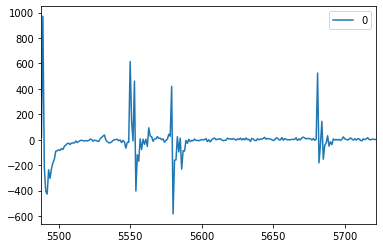

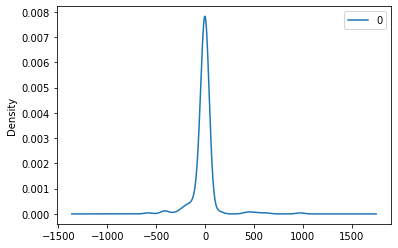

In [68]:
#https://stackoverflow.com/questions/14016247/find-integer-index-of-rows-with-nan-in-pandas-dataframe

# fit model
model = ARIMA(series[0:ind_sets[0][0]], order=(4,2,4))
model_fit = model.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
#print(residuals.describe())

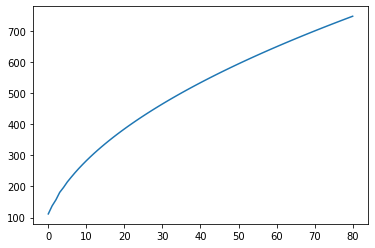

In [70]:
new_points = model_fit.forecast(ind_sets[0][1]-ind_sets[0][0])
plt.plot(new_points[1])

the areas with no values are usually split up and we don't want to predict values that already exist, so I made a function to get the beginning and ending indices of these NA areas

In [105]:
#attempt at replacing missing values with arima prediction (doesn't work so great)
plt.figure()
plt.plot(pm_na[pm_na.dev_id==7]['co2'])
series = pm_na[pm_na.dev_id==7]['co2']
plt.figure()
plt.plot(series)
replacement_sets=[]
for set in ind_sets:
    replacements=model_fit.predict(start=set[0],end=set[1])
    replacement_sets.append(replacements)
    for i in range(set[0],set[1]):
        j = i + series.index[0]
        series[j]=replacements[j]+series[set[0]-1]
plt.figure()
for set in replacement_sets:
    plt.plot(set)
plt.figure()
plt.plot(series)

KeyError: 5723

### Kalman Smoothing

https://pykalman.github.io/#pykalman.KalmanFilter.em

seems to just shrink the y axis

the difference between linear interpolation and kalman smoothing is unnoticeable, am I parameterizing this incorrectly?

running this in R gave the same results: basically just linear interpolation.

does this method not work for large swathes of missing data? It seems to work really well in general from what I've read

In [21]:
series = pm_na[pm_na.dev_id==7]['co2']
inds = pm_na[pm_na.dev_id==7]['co2'].isnull()
inds = [1 if x else 0 for x in inds]
series_masked = ma.array(list(series),mask=inds)

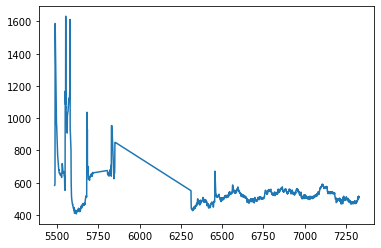

In [22]:
plt.plot(pm_na[pm_na.dev_id==7]['co2'].interpolate())

In [23]:
kf = pk.KalmanFilter(initial_state_mean=100, n_dim_obs=1)
kfem = kf.em(series_masked,n_iter=5)
series_smoothed = kfem.smooth(series_masked)

Generating values from the distribution found from kf.em gives realistic, albeit including negative, values

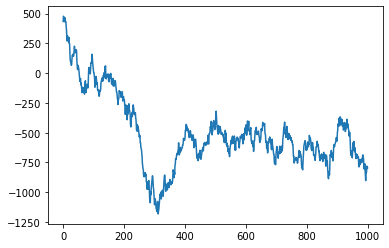

In [24]:
plt.plot(kfem.sample(1000)[0])

However the resulting predictions for our data become straight lines?

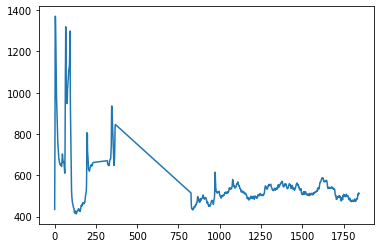

In [25]:
series_smoothed = kfem.smooth(series_masked)
plt.plot(series_smoothed[0])

# Weather data

In [26]:
pwsIDs = [105, 171, 111, 136, 112, 80, 106, 176, 134, 8]

In [27]:
geo = pd.read_csv('../data/geo.csv')

In [28]:
weatherData = pd.read_csv("../data/2020-01-01,2020-02-22.csv")

In [29]:
weatherData=weatherData.join(geo.set_index('pws'),on="pws")

In [30]:
weatherData['DateTime']=[dt.strptime(x,'%Y-%m-%d %I:%M %p') for x in (weatherData.date + " " + weatherData.Time)]

In [31]:
weatherData.head()

,Unnamed: 0,Time,Temperature,Dew Point,Humidity,Wind,Speed,Gust,Pressure,Precip. Rate.,...,UV,Solar,date,pws,lat,lat_dir,long,long_dir,elevation,DateTime
0,1,12:04 AM,41.5 F,27.5 F,57 %,NE,0.0 mph,0.0 mph,29.19 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:04:00
1,2,12:09 AM,41.5 F,27.5 F,57 %,NE,0.0 mph,0.0 mph,29.19 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:09:00
2,3,12:14 AM,41.4 F,27.6 F,58 %,ESE,0.1 mph,0.2 mph,29.19 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:14:00
3,4,12:19 AM,41.2 F,27.9 F,59 %,SE,0.0 mph,0.2 mph,29.20 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:19:00
4,5,12:24 AM,41.0 F,27.9 F,59 %,SE,0.0 mph,0.0 mph,29.20 in,0.00 in,...,0.0,0 w/m²,2020-01-01,171.0,38.046,N,78.495,E,581,2020-01-01 00:24:00


# make dataframe for predictions
## for each of PM2.5,PM10,C02 there is a dataframe where each row contains:
- response variable = one of the 10 AQ stations
- features:
    - the other 9 AQ station features and their distances to the response station
    - all 10 weather station features and their distance to the response station
- one record per 5 minutes

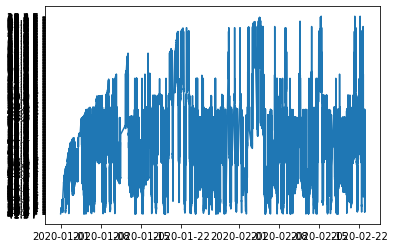

In [34]:
plt.plot(weatherData[weatherData.pws==171.0].DateTime,weatherData[weatherData.pws==171.0].Temperature)

In [35]:
gmaps.configure(api_key=auth.gmaps['api_key']) # Your Google API key

In [36]:
#weather data one reading per 5 mins
#pm data one reading per 15 mins
#must move through time and for each 5 mins get the closest data point for each weather station and each AQ station
#each row has predictors from all stations with one AQ station removed
#thus we have the same # of rows as the weather data because 1 row for each of the 10 stations is combined into 1 row
#all of the AQ data is applied, and then it is multiplied out by 10 for predicting each of the AQ stations

In [37]:
pmData=pmData.sort_values(by=['DateTime'])
weatherData=weatherData.sort_values(by=['DateTime'])

KeyError: 'DateTime'

In [102]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
series = pm_na[pm_na.dev_id==7]['co2'].interpolate()
inds = np.where(pm_na[pm_na.dev_id==7]['co2'].isnull())[0]
ind_sets = findConsecutives(inds)

for param in pdq:
    try:
        mod = ARIMA(series, order=param)
        results = mod.fit()

        print('ARIMA{}x - AIC:{}'.format(param, results.aic))
    except:
        continue

ARIMA(0, 0, 4)x - AIC:19790.53372453084
ARIMA(0, 0, 5)x - AIC:19617.291095794542
ARIMA(0, 0, 6)x - AIC:19448.73435896732
ARIMA(0, 1, 4)x - AIC:18928.197117216343
ARIMA(0, 1, 5)x - AIC:18926.768461170825
ARIMA(0, 1, 6)x - AIC:18927.543174300637
ARIMA(1, 0, 4)x - AIC:18924.960243219713
ARIMA(1, 0, 5)x - AIC:18925.834649129523
ARIMA(1, 0, 6)x - AIC:18927.623193224958
ARIMA(1, 1, 4)x - AIC:18925.54461767945
ARIMA(1, 1, 5)x - AIC:18908.553412222052
ARIMA(1, 1, 6)x - AIC:18921.234703668535
ARIMA(1, 2, 6)x - AIC:18922.327118644436
ARIMA(2, 0, 4)x - AIC:18925.655617959146
ARIMA(2, 0, 5)x - AIC:18922.207766174215
ARIMA(2, 0, 6)x - AIC:18920.18119270142
ARIMA(2, 1, 4)x - AIC:18922.703013753573
ARIMA(2, 1, 5)x - AIC:18909.568177796795
ARIMA(2, 1, 6)x - AIC:18901.68738632803
ARIMA(3, 0, 4)x - AIC:18926.27161361504
ARIMA(3, 0, 5)x - AIC:18923.593506923207
ARIMA(3, 0, 6)x - AIC:18915.59536840057
ARIMA(3, 1, 4)x - AIC:18915.789843884268


ARIMA(0, 0, 4)x - AIC:19790.53372453084
ARIMA(0, 0, 5)x - AIC:19617.291095794542
ARIMA(0, 0, 6)x - AIC:19448.73435896732
ARIMA(0, 1, 4)x - AIC:18928.197117216343
ARIMA(0, 1, 5)x - AIC:18926.768461170825
ARIMA(0, 1, 6)x - AIC:18927.543174300637
ARIMA(1, 0, 4)x - AIC:18924.960243219713
ARIMA(1, 0, 5)x - AIC:18925.834649129523
ARIMA(1, 0, 6)x - AIC:18927.623193224958
ARIMA(1, 1, 4)x - AIC:18925.54461767945
ARIMA(1, 1, 5)x - AIC:18908.553412222052
ARIMA(1, 1, 6)x - AIC:18921.234703668535
ARIMA(1, 2, 6)x - AIC:18922.327118644436
ARIMA(2, 0, 4)x - AIC:18925.655617959146
ARIMA(2, 0, 5)x - AIC:18922.207766174215
ARIMA(2, 0, 6)x - AIC:18920.18119270142
ARIMA(2, 1, 4)x - AIC:18922.703013753573
ARIMA(2, 1, 5)x - AIC:18909.568177796795
ARIMA(2, 1, 6)x - AIC:18901.68738632803
ARIMA(3, 0, 4)x - AIC:18926.27161361504
ARIMA(3, 0, 5)x - AIC:18923.593506923207
ARIMA(3, 0, 6)x - AIC:18915.59536840057
ARIMA(3, 1, 4)x - AIC:18915.789843884268
ARIMA(3, 1, 5)x - AIC:18911.038659435922
